In [1]:
import numpy as np 
from matplotlib import pyplot as plt 
import math
import os

In [40]:
class PGMImage:
    def __init__(self, file_path=None):
        self.magic_number = None
        self.width = 0
        self.height = 0
        self.maxval = 0
        self.pixels = []

        if file_path:
            self.mypgmread(file_path)

    def mypgmread(self, file_path):
        with open(file_path, 'rb') as file:
            self.magic_number = file.readline().strip().decode('ascii')

            line = file.readline().strip()
            while line.startswith(b'#'): 
                line = file.readline().strip()

            self.width, self.height = map(int, line.split())
            self.maxval = int(file.readline().strip())
            data = file.read()
            self.pixels = list(data)

    def modify_pixels(self, row_start, row_end, new_value):
        pixels_2d = np.array(self.pixels, dtype=np.uint8).reshape((self.height, self.width))
        pixels_2d[row_start:row_end, :] = new_value
        self.pixels = pixels_2d.flatten().tolist()

    def mypgmwrite(self, filename):
        pixel_array = np.array(self.pixels, dtype=np.uint8).reshape((self.height, self.width))

        with open(filename, 'wb') as file:
            file.write(f"{self.magic_number}\n".encode())
            file.write(f"{self.width} {self.height}\n".encode())
            file.write(f"{self.maxval}\n".encode())
            pixel_array.tofile(file)

####################################################################################################
############################## LAB-01 FONKSİYONLARI ################################################
####################################################################################################

    def myImageLinearScale(self, pixel_array): # pixel değerlerini normalize etme fonksiyonu
        max_pixel_value = np.max(self.pixels) # pixel değerinin maksimum değerini belirler
        # pixels listesindeki her değeri max değere böler ve 0-1 aralığına getirir, maxvalin değeri olan 255 ile çarpar
        self.pixels = [int(self.maxval * (pixel / max_pixel_value)) for pixel in self.pixels]
        return self.pixels

    
    def myImageNegative(self): # görüntünün negatifini alma fonksiyonu
        # her bir pixel değerini max değerden çıkarır böylelikle bütü değerler ters çevirilmiş olur
        self.pixels = [self.maxval - pixel for pixel in self.pixels] 
        self.pixels = self.myImageLinearScale(self.pixels) # pixeller scale edilir

    def myImageLogTransform(self): # log transformu fonksiyonu
        # her bir pixel değeri için ders kitabındaki logaritma formül uygulanmıştır.
        self.pixels = [np.log(1 + pixel) for pixel in self.pixels]
        self.pixels = self.myImageLinearScale(self.pixels) # pixeller scale edilir
        
        
    def myImageGammaTransform(self, gamma): # gama transformu fonksiyonu girdi olarak gamanın değeri verilebilir
        # yine her bir pixel için ders kitbında verilen Power-Laz(gama) formülü uygulanır
        self.pixels = [int(self.maxval * (pixel / self.maxval) ** gamma) for pixel in self.pixels]
        self.pixels = self.myImageLinearScale(self.pixels) # pixeller scale edilir


    def myImageCorrelation(self, kernel): # kernel dışarıdan verilir
        k_height, k_width = kernel.shape # kernelin yükseklik ve genişliği .shape ile elde edilir
        g = np.zeros((self.height, self.width), dtype=np.float32) # çıkış değerini tutmak için imagein boyutlarında 0'lardan oluşan liste oluşturulur
        pixels_2d = np.array(self.pixels, dtype=np.uint8).reshape((self.height, self.width)) # orjinal imagein pixelleri boyutlandırlır
        
        for x in range(0 , self.height): # orjinal görüntünün her pixelinde işlem yapmak için for döngüsü kurulur
            for y in range(0, self.width):
                for s in range(-k_height//2, k_height//2): # kernelin her bir değerinde işlem yapmak için for döngüleri kurulur
                    for t in range(-k_width//2, k_width//2):
                        if x+s >= 0 and x+s < self.height and y+t >= 0 and y+t < self.width: # sınır noktalar tanımlanır
                                g[x][y] += kernel[s][t] * pixels_2d[x+s][y+t] # çıkış değerine kernelin ile orjinal görüntünün her bir pixel değeriyle çarpılıp toplanmış değeri atanır
        
        self.pixels = self.myImageLinearScale(self.pixels) # pixeller scale edilir
        return g # çıkış değeri iki boyutlu olarak döndürülür

    def myImageMedianFilter(self, k_height, k_width):
        g = np.zeros((self.height, self.width), dtype=np.float32)
        pixels_2d = np.array(self.pixels, dtype=np.uint8).reshape((self.height, self.width))
        for x in range(0 , self.height):
            for y in range(0, self.width):
                kernel_array = [] # kernel in içindeki her bir değeri tutmak için oluşturulur
                for s in range(-k_height//2, k_height//2): # kernelin her bir değerini döner
                    for t in range(-k_width//2, k_width//2):
                        if x+s >= 0 and x+s < self.height and y+t >= 0 and y+t < self.width: 
                            kernel_array.append(pixels_2d[x+s][y+t]) # komşu pixelleri listenin içinde tutar
                g[x][y] = np.median(kernel_array) # komşu pixellerin medianını alır ve orjinal görüntünün o an işlenen pixeline yazar
        self.pixels = self.myImageLinearScale(self.pixels) # pixeller scale edilir

        return g  # çıkış değeri iki boyutlu olarak döndürülür
        

Görüntünün Negatifinin alınması, myImageNegative() fonksiyonunun uygulanması

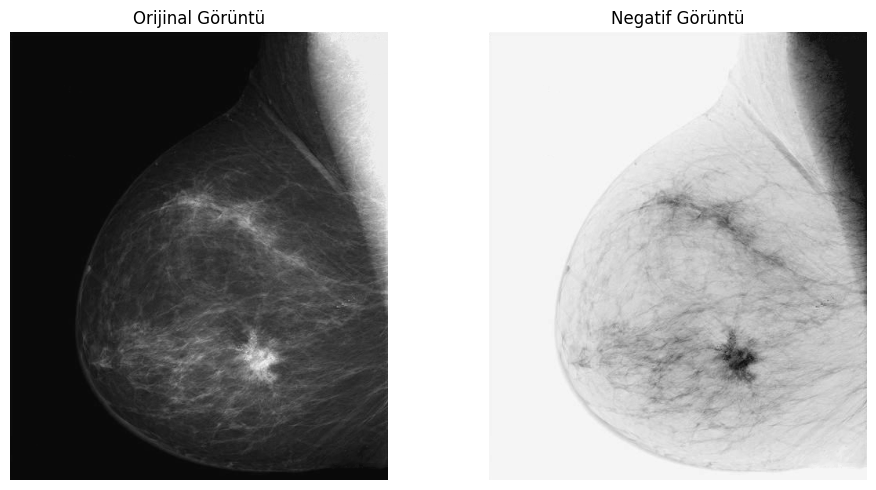

In [53]:
# orjinal görüntü alınır
pgm_image = PGMImage('Fig0304(a)(breast_digital_Xray).pgm')

original_image = np.array(pgm_image.pixels, dtype=np.uint8).reshape((pgm_image.height, pgm_image.width))
# fonksiyon çağırılır
pgm_image.myImageNegative()
#pixeller boyutlandırılır
log_image = np.array(pgm_image.pixels, dtype=np.uint8).reshape((pgm_image.height, pgm_image.width))

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title("Orijinal Görüntü")
plt.axis('off')
plt.imshow(original_image, cmap='gray')

plt.subplot(1, 2, 2)
plt.title("Negatif Görüntü")
plt.axis('off')
plt.imshow(log_image, cmap='gray')

plt.tight_layout()

myImageLogTransform() fonksiyonunun kullanılması

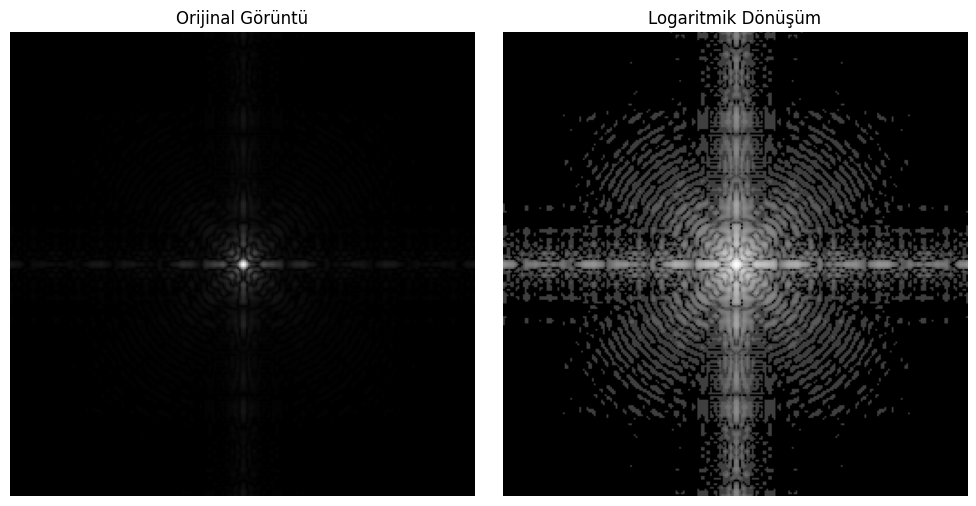

0


In [52]:
pgm_image = PGMImage('Fig0305(a)(DFT_no_log).pgm')

original_image = np.array(pgm_image.pixels, dtype=np.uint8).reshape((pgm_image.height, pgm_image.width))
pgm_image.myImageLogTransform()
log_image = np.array(pgm_image.pixels, dtype=np.uint8).reshape((pgm_image.height, pgm_image.width))


plt.figure(figsize=(10, 5))

# Orijinal görüntü
plt.subplot(1, 2, 1)
plt.title("Orijinal Görüntü")
plt.axis('off')
plt.imshow(original_image, cmap='gray')

# Logaritmik dönüşüm uygulanmış görüntü
plt.subplot(1, 2, 2)
plt.title("Logaritmik Dönüşüm")
plt.axis('off')
plt.imshow(log_image, cmap='gray')

plt.tight_layout()
plt.show()


Gama Transformunun uygulanması myImageGammaTransform()

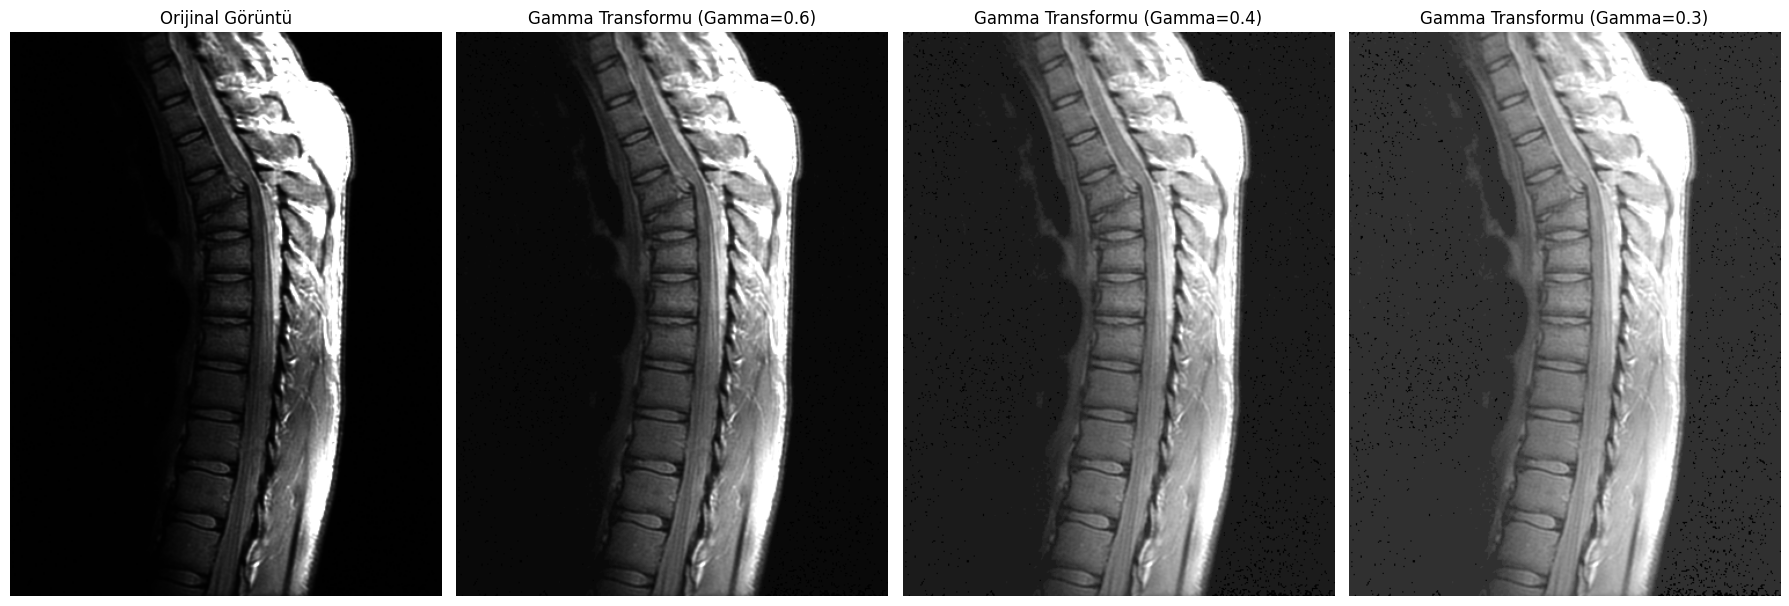

In [51]:
pgm_image = PGMImage('Fig0308(a)(fractured_spine).pgm')
original_image = np.array(pgm_image.pixels, dtype=np.uint8).reshape((pgm_image.height, pgm_image.width))

# gama değerleri beirlenir
gamma1 = 0.6
gamma2 = 0.4
gamma3 = 0.3

pgm_image.pixels = original_image.flatten().tolist()
pgm_image.myImageGammaTransform(gamma1)
gamma_transformed_image_1 = np.array(pgm_image.pixels, dtype=np.uint8).reshape((pgm_image.height, pgm_image.width))

pgm_image.pixels = original_image.flatten().tolist()
pgm_image.myImageGammaTransform(gamma2)
gamma_transformed_image_2 = np.array(pgm_image.pixels, dtype=np.uint8).reshape((pgm_image.height, pgm_image.width))

pgm_image.pixels = original_image.flatten().tolist()
pgm_image.myImageGammaTransform(gamma3)
gamma_transformed_image_3 = np.array(pgm_image.pixels, dtype=np.uint8).reshape((pgm_image.height, pgm_image.width))

plt.figure(figsize=(18, 6))

plt.subplot(1, 4, 1)
plt.title('Orijinal Görüntü')
plt.imshow(original_image, cmap='gray')
plt.axis('off')

plt.subplot(1, 4, 2)
plt.title(f'Gamma Transformu (Gamma={gamma1})')
plt.imshow(gamma_transformed_image_1, cmap='gray')
plt.axis('off')

plt.subplot(1, 4, 3)
plt.title(f'Gamma Transformu (Gamma={gamma2})')
plt.imshow(gamma_transformed_image_2, cmap='gray')
plt.axis('off')

plt.subplot(1, 4, 4)
plt.title(f'Gamma Transformu (Gamma={gamma3})')
plt.imshow(gamma_transformed_image_3, cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()

myImageCorrelation() fonnksiyonunun 5 farklı boyutta kernel ile uygulanması

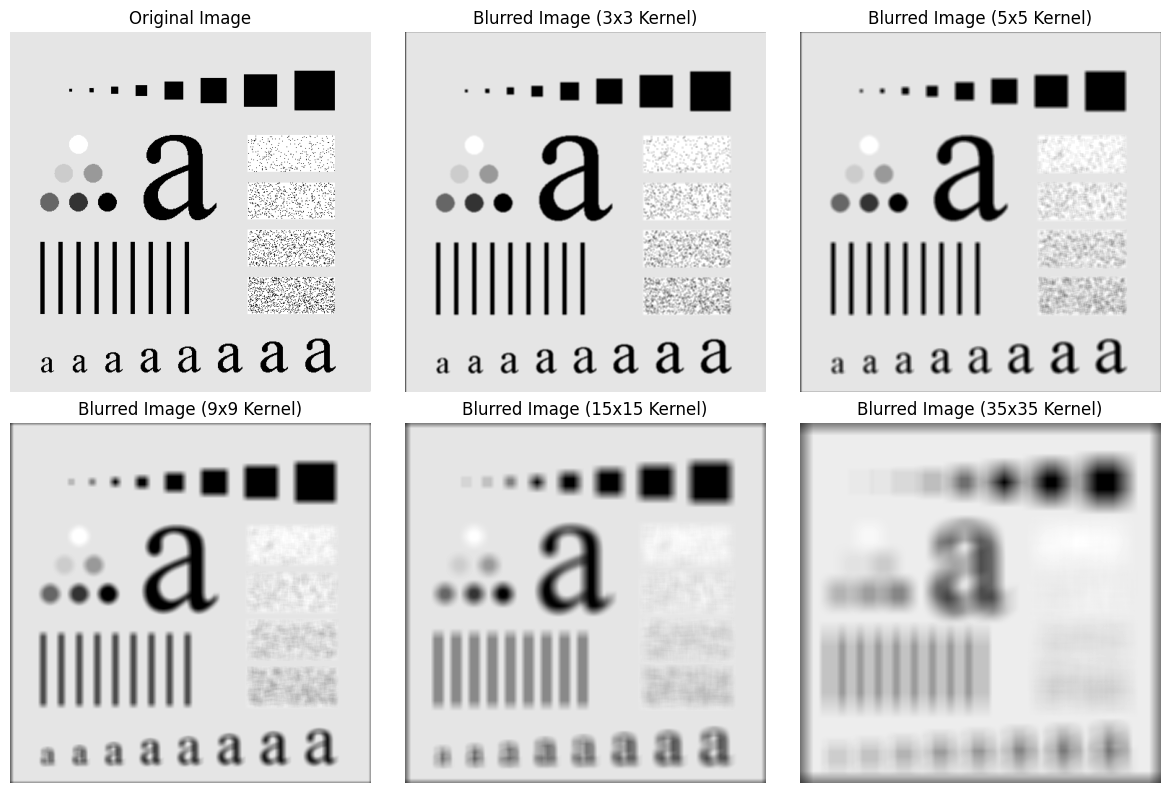

In [47]:
kernel_1 = np.ones((3, 3), dtype=float)
kernel_2 = np.ones((5, 5), dtype=float) 
kernel_3 = np.ones((9, 9), dtype=float) 
kernel_4 = np.ones((15, 15), dtype=float)  
kernel_5 = np.ones((35, 35), dtype=float)   

pgm_image = PGMImage('Fig0333(a)(test_pattern_blurring_orig).pgm')

original_image = np.array(pgm_image.pixels, dtype=np.uint8).reshape((pgm_image.height, pgm_image.width))

blurred_m3 = pgm_image.myImageCorrelation(kernel_1)
pgm_image.pixels = original_image.flatten().tolist() # fonskiyon çağırıldıktan sonra self.pixels değeri değiştiğinden tekrar orjinal pixeller değerleri alınır

blurred_m5 = pgm_image.myImageCorrelation(kernel_2)
pgm_image.pixels = original_image.flatten().tolist()

blurred_m9 = pgm_image.myImageCorrelation(kernel_3)
pgm_image.pixels = original_image.flatten().tolist()

blurred_m15 = pgm_image.myImageCorrelation(kernel_4)
pgm_image.pixels = original_image.flatten().tolist()

blurred_m35 = pgm_image.myImageCorrelation(kernel_5)

plt.figure(figsize=(12, 8))

plt.subplot(2, 3, 1)
plt.title('Original Image')
plt.imshow(original_image, cmap='gray')
plt.axis('off')

plt.subplot(2, 3, 2)
plt.title('Blurred Image (3x3 Kernel)')
plt.imshow(blurred_m3, cmap='gray')
plt.axis('off')

plt.subplot(2, 3, 3)
plt.title('Blurred Image (5x5 Kernel)')
plt.imshow(blurred_m5, cmap='gray')
plt.axis('off')

plt.subplot(2, 3, 4)
plt.title('Blurred Image (9x9 Kernel)')
plt.imshow(blurred_m9, cmap='gray')
plt.axis('off')

plt.subplot(2, 3, 5)
plt.title('Blurred Image (15x15 Kernel)')
plt.imshow(blurred_m15, cmap='gray')
plt.axis('off')

plt.subplot(2, 3, 6)
plt.title('Blurred Image (35x35 Kernel)')
plt.imshow(blurred_m35, cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()

myImageMedianFilter() ve myImageCorrelation() fonksiyonlarının uygulanması

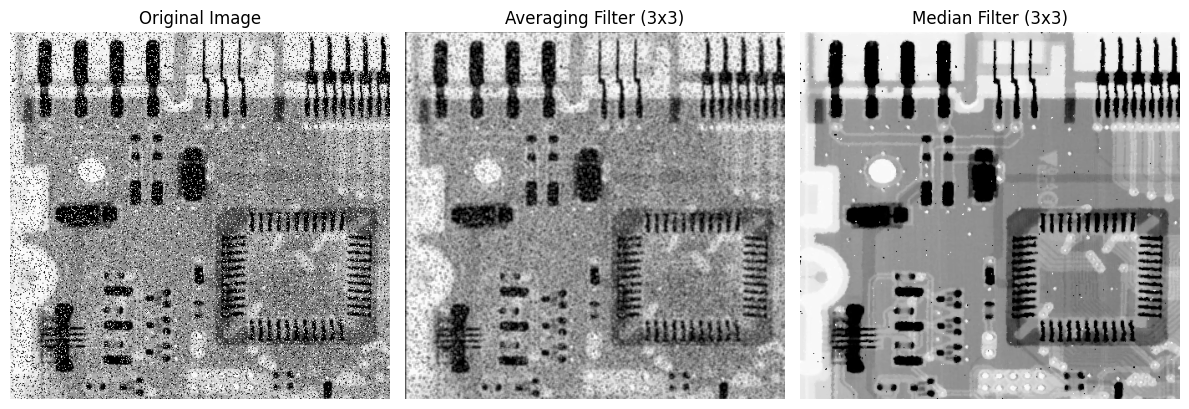

In [45]:
pgm_image = PGMImage('Fig0335(a)(ckt_board_saltpep_prob_pt05).pgm')

original_image = np.array(pgm_image.pixels, dtype=np.uint8).reshape((pgm_image.height, pgm_image.width))

kernel_1 = np.ones((3, 3), dtype=float) 

avg_mask_3_3 = pgm_image.myImageCorrelation(kernel_1)
pgm_image.pixels = original_image.flatten().tolist()

median_mask_3_3 = pgm_image.myImageMedianFilter(3,3)

plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.title('Original Image')
plt.imshow(original_image, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title('Averaging Filter (3x3)')
plt.imshow(avg_mask_3_3, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title('Median Filter (3x3)')
plt.imshow(median_mask_3_3, cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()